In [1]:
library("ape")
library("phytools")
library("caper")
library("geiger")
library("readxl")
library("tidyverse")

Loading required package: maps

Loading required package: MASS

Loading required package: mvtnorm

── Attaching core tidyverse packages ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.4.4     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
✖ purrr::map()    masks maps::map()
✖ dplyr::select() masks MASS::select()
✖ dplyr::where()  masks ape::where()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) t

In [5]:
change_species_in_bergeron_tree_to_lowercase <- function(tree_filename) {
    tree <- read.tree(tree_filename)
    cat("binary:", is.binary(tree), "\n") 
    cat("ultrametric:", is.ultrametric(tree), "\n")
    # 74 species in original tree
    for (nn in tree$tip.label) {
      tmp <- tolower(nn)
      tree$tip.label <- stringr::str_replace_all(tree$tip.label, nn, tmp)
    }
    return(tree)
}

load_and_process_csv <- function(csv_filename) {
    df <- read.csv(csv_filename)
    # column names: "species", "group", "perc_CpG.TpG", "mutation.count", "gen_time", "u_year_non_modeled", "u_modeled", "u_gen_non_modeled", 
    # "u_CpG_gen_non_modeled", "u_CpG_year_non_modeled" "diversity", "Ne", "Ne.g"  
    rownames(df) <- df$species
    df$log_u_gen <- log10(df$u_gen_non_modeled)
    df$log_u_year <- log10(df$u_year_non_modeled)
    df$log_Ne <- log10(df$Ne)
    df$log_Ne.gen <- log10(df$Ne.g)
    df$log_gen_year <- log10(df$gen_time)
    df = dplyr::select(df, species, log_u_gen, log_u_year, log_Ne, log_Ne.gen, log_gen_year)
    return (df)
}

trim_tree_branches <- function (tree, df) {
    # trim off tree branches corresponding to species that are not found in the dataframe
    name_check <- name.check(tree, df)
    new_tree <- drop.tip(tree, name_check$tree_not_data)
    name.check(new_tree, df)
    return(new_tree)
}

load_and_trim_bergerons_tree <- function(df) {
    tree_orig = change_species_in_bergeron_tree_to_lowercase("./output/calibrated_bergeron_tree.nwk")
    tree_trim = trim_tree_branches(tree_orig, df)
    cat(length(tree_orig$tip.label), "species in the original tree,", length(tree_trim$tip.label), "species in the trimmed tree\n")
    cat(nrow(df), "species in the dataframe\n")
    return(tree_trim)
}

In [6]:
# lower case version of species name in Wang's tree
wang_tree_map_to_bergeron_species_name <- c(
    'pelecanus_occidentalis' = 'pelecanus_crispus',
    'phoenicopterus' = 'phoenicopterus_roseus',
    'cyanistes_caeruleus_caeruleus' = 'cyanistes_caeruleus',
    'turdus_merula_merula' = 'turdus_merula',
    'gyps' = 'gyps_fulvus', 
    'homo_sapiens_neanderthalensis' = 'homo_sapiens',
    'pan_troglodytes_troglodytes' = 'pan_troglodytes', 
    'hylobates_lar_lar' = 'hylobates_lar', 
    'cavia_aperea_guianae' = 'cavia_aperea',
    'mus_musculus_musculus' = 'mus_musculus', 
    'cervus_hanglu' = 'cervus_elaphus_yarkandensis',
    'cervus_nippon_centralis' = 'cervus_nippon',
    'giraffa_reticulata' = 'giraffa_camelopardalis',
    'ceratotherium_simum' = 'ceratotherium_simum_simum',
    'ailurus' = 'ailurus_fulgens',
    'neogale_vison' = 'neovison_vison'
)

wang_tree_map_to_bergeron_species_name <- c(
    'pelecanus_crispus' = 'pelecanus_occidentalis',
    'ceratotherium_simum' = 'ceratotherium_simum_mum',
}s

load_and_trim_wangs_tree <- function(df, wang_tree_map_to_bergeron_species_name) {
    tree <- read.tree("./data/filtered_unique_species.nwk")
    cat("binary:", is.binary(tree), "\n") 
    cat("ultrametric:", is.ultrametric(tree), "\n")
    # 126 species, 250 edges
    length(tree$tip.label) 
    # convert to lower case
    for(nn in tree$tip.label){
        tmp <- tolower(nn)
        map_name = wang_tree_map_to_bergeron_species_name[tmp]
        if (!is.na(map_name)) {
            tmp <- map_name
        }
        tree$tip.label <- stringr::str_replace_all(tree$tip.label, nn, tmp)
    }
    name_check <- name.check(tree, df)
    tree_trim <- drop.tip(tree, name_check$tree_not_data)
    cat(length(tree$tip.label), "species in the original tree,", length(tree_trim$tip.label), "species in the trimmed tree\n")
    cat(nrow(df), "species in the dataframe\n")
    return(tree_trim)
}

In [7]:
cat("Bergeron's tree: \n")
df = load_and_process_csv("./output/df_bergeron_merge.csv")
tree_berg = load_and_trim_bergerons_tree(df)

cat("\nWang's tree:\n")
tree_wang <- load_and_trim_wangs_tree(df, wang_tree_map_to_bergeron_species_name)
label_diff <- setdiff(tree_berg$tip.label, tree_wang$tip.label)
cat("number of different species in bergeron's tree vs wang's", length(label_diff), "\n")

Bergeron's tree: 
binary: TRUE 
ultrametric: TRUE 
74 species in the original tree, 62 species in the trimmed tree
62 species in the dataframe

Wang's tree:
binary: TRUE 
ultrametric: TRUE 
126 species in the original tree, 62 species in the trimmed tree
62 species in the dataframe
number of different species in bergeron's tree vs wang's 0 


In [8]:
run_pgls <- function(df, tree, x_name, y_name, lambda, print_plot) {
    taxa <- comparative.data(tree, df, "species", vcv=TRUE)
    fm <- as.formula(paste(y_name, "~", x_name))
    model <- pgls(formula=fm, data=taxa, lambda=lambda)
    coeff <- coefficients(model)
    intercept <- coeff[1]
    slope <- coeff[2]
    Ne_u_plot <- ggplot(data=df, aes_string(x=x_name, y=y_name)) + geom_point()
    Ne_u_plot <- Ne_u_plot + geom_smooth(formula=y~x, method="lm") + geom_abline(intercept = intercept, slope = slope)
    if (print_plot) {
        print(Ne_u_plot + labs(y=y_name, x=x_name))
    }

    res<- residuals(model, phylo = TRUE)
    res<- res/sqrt(var(res))[1]
    
    return(model)
}

save_summary_data <- function(model, print_output, save_output, save_filename="output_file.csv") {
    model_summary <- summary(model)
    # names(summary(model_summary))
    lambda <- model_summary$param.CI$lambda$opt
    lambda.ci.val <- model_summary$param.CI$lambda$ci.val
    lambda.bounds <- model_summary$param.CI$lambda$bounds.val
    lambda.p <- model_summary$param.CI$lambda$bounds.p
    
    coeff <- model_summary$coefficients[,1]
    coeff.p <- model_summary$coefficients[,4]
    if (print_output) {
        cat("lambda: ", lambda, ", CI of lambda: ", lambda.ci.val, "\n")
        cat("coefficients: ", coeff, ", p-value: ", coeff.p, "\n")
    }

    if (save_output) {
        df_out <- t(data.frame(c(lambda, lambda.ci.val, lambda.bounds, lambda.p, coeff, coeff.p)))
        colnames(df_out) <- c("lambda", "lambda.ci.low", "lambda.ci.high", "lambda.bounds.low", "lambda.bounds.high", "lambda.p.low", "lambda.p.high", "intercept", "slope", "intercept.p", "slope.p")
        rownames(df_out) <- c(1)
        write.csv(df_out, save_filename)
    }
}

## Clocklike DBH plots, mutation rate (per year, per generation) vs Ne (* generation time)

Warning message:
“`aes_string()` was deprecated in ggplot2 3.0.0.
ℹ Please use tidy evaluation idioms with `aes()`.
ℹ See also `vignette("ggplot2-in-packages")` for more information.”


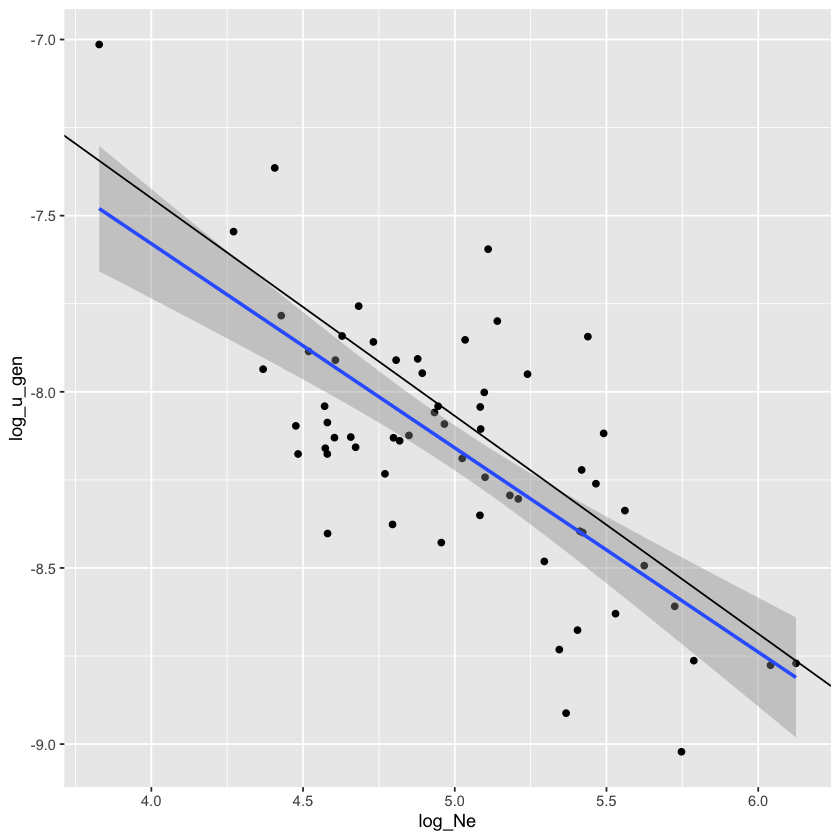

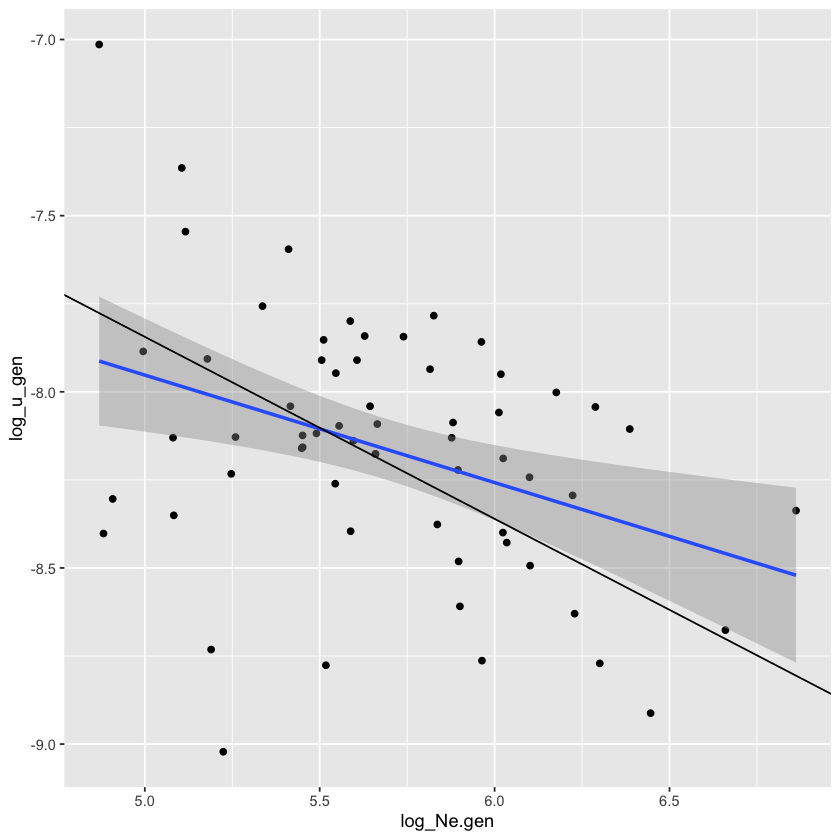

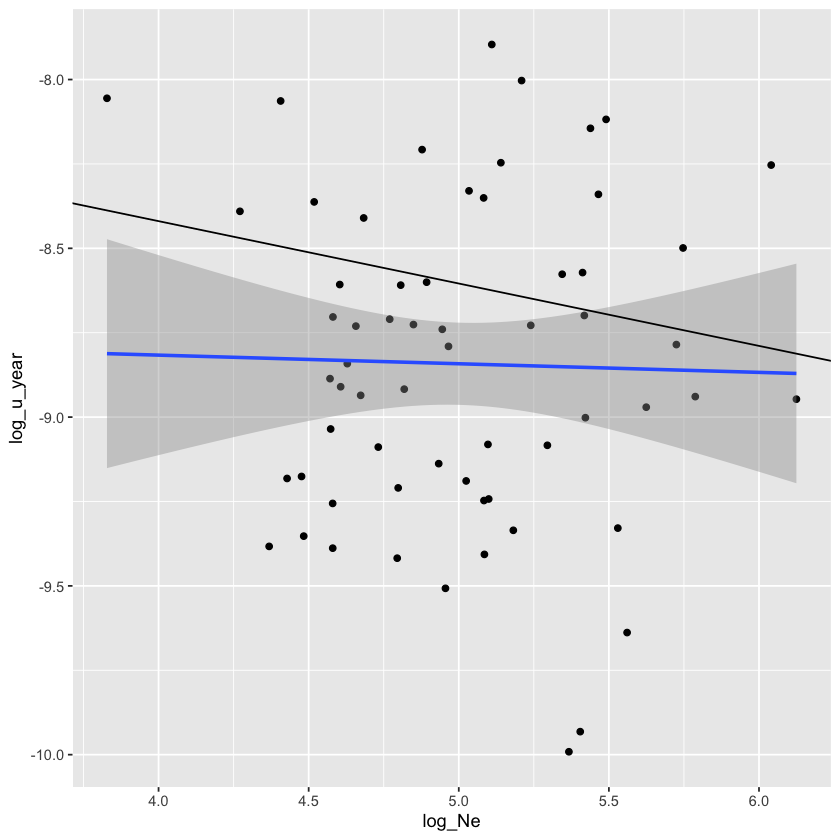

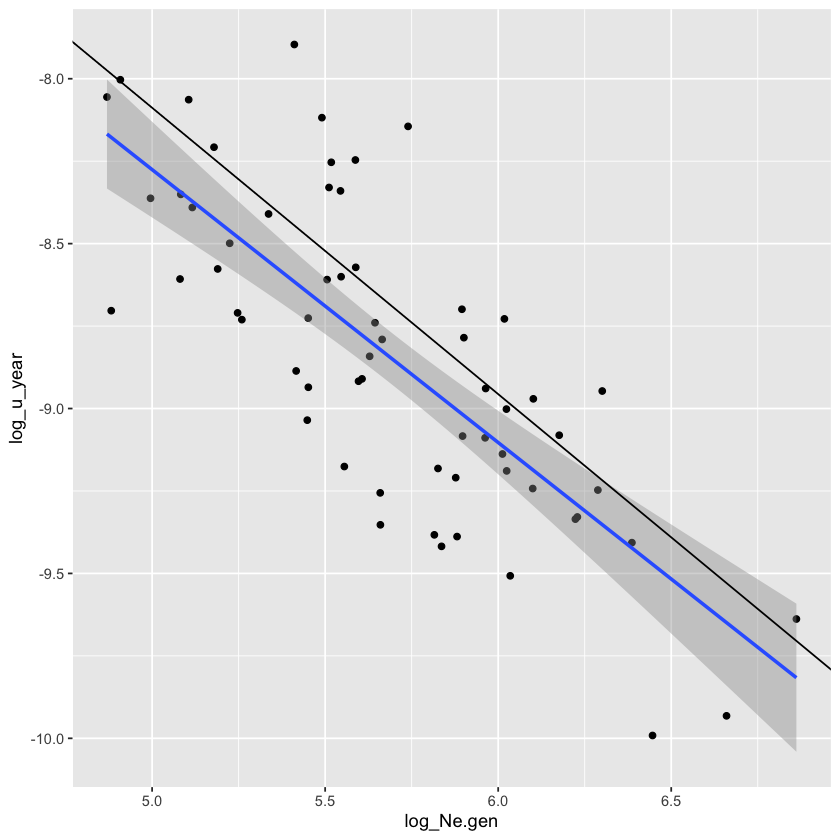

In [9]:
lambda <- "ML"
model.u_gen.Ne <- run_pgls(df, tree_berg, "log_Ne", "log_u_gen", lambda=lambda, print_plot=TRUE)
model.u_gen.Ne_g <- run_pgls(df, tree_berg, "log_Ne.gen", "log_u_gen", lambda=lambda, print_plot=TRUE)
model.u_year.Ne <- run_pgls(df, tree_berg, "log_Ne", "log_u_year", lambda=lambda, print_plot=TRUE)
model.u_year.Ne_g <- run_pgls(df, tree_berg, "log_Ne.gen", "log_u_year", lambda=lambda, print_plot=TRUE)

## Reviewer 1, yearly mutation rate on generation time

lambda 
 1e-06

[1]        NA 0.7318077

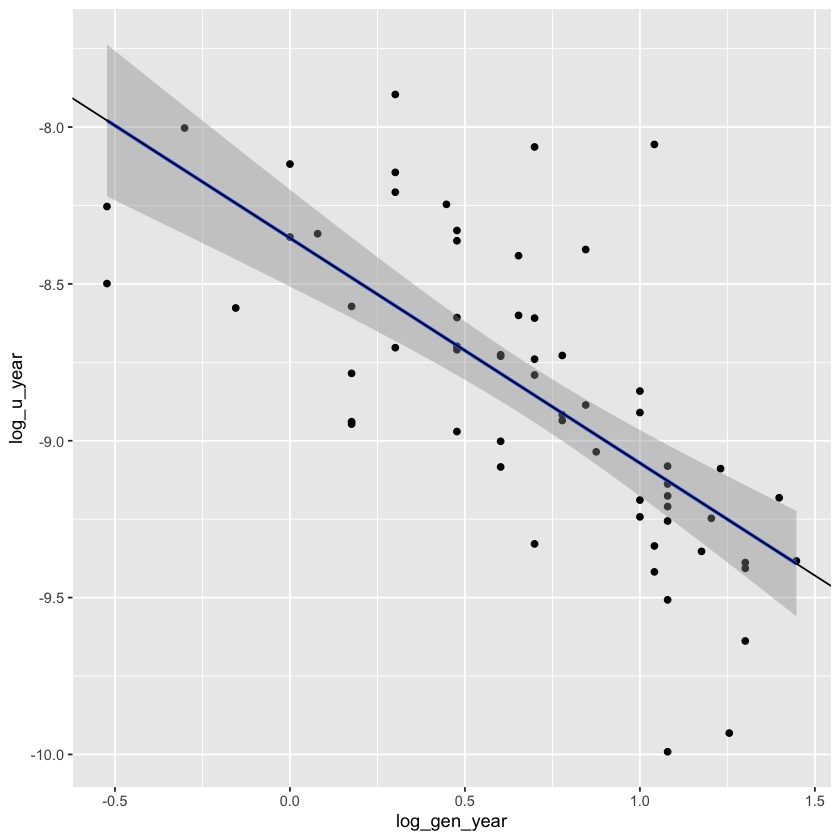

In [13]:
lambda <- "ML"
model.u_year.g <- run_pgls(df, tree_berg, "log_gen_year", "log_u_year", lambda=lambda, print_plot=TRUE)
summary(model.u_year.g)$param.CI$lambda$opt
summary(model.u_year.g)$param.CI$lambda$ci.val
save_summary_data(model.u_year.g, print_output=FALSE, save_output=TRUE, save_filename="output/r_bergeron/mu_year_gen.csv")

lambda 
 1e-06

[1]       NA 0.454143

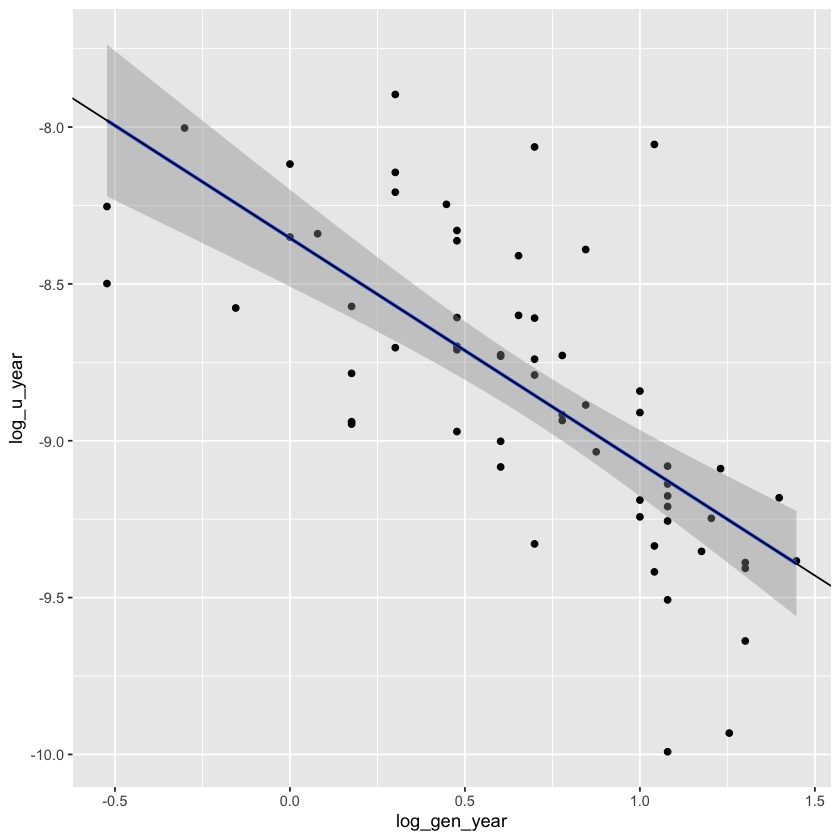

In [11]:
lambda <- "ML"
model.u_year.g <- run_pgls(df, tree_wang, "log_gen_year", "log_u_year", lambda=lambda, print_plot=TRUE)
summary(model.u_year.g)$param.CI$lambda$opt
summary(model.u_year.g)$param.CI$lambda$ci.val